# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.43KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

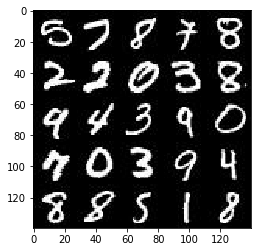

In [2]:

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

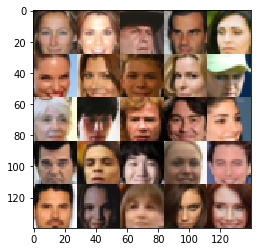

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [36]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [40]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #lrelu
    def lrelu(x, alpha):
        return tf.nn.relu(x) - alpha * tf.nn.relu(-x)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #Input is 28X28Xdim
        #No batch normalization at input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                              padding='same')
        x1 = lrelu(x1, alpha)
        x1 = tf.nn.dropout(x1, keep_prob=0.9)
        #14X14X64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, 
                              padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = lrelu(x2, alpha)
        x2 = tf.nn.dropout(x2, keep_prob=0.9)
        #7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2,
                              padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = lrelu(x3, alpha)
        x3 = tf.nn.dropout(x3, keep_prob=0.9)
        #4X4X256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        #fully connected input
        x1 = tf.layers.dense(z, 7*7*256)
        #Reshaped to a 4-d tensor
        x1 = tf.reshape(x1, (-1,7,7,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        #7X7X256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.8)
        #14X14X128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.8)
        #28X28X64
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.nn.relu(x4)
        x4 = tf.nn.dropout(x4, keep_prob=0.8)
        #28X28X32
        
        x5 = tf.layers.conv2d_transpose(x4, 16, 5, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.nn.relu(x5)
        x5 = tf.nn.dropout(x5, keep_prob=0.8)
        
        x6 = tf.layers.conv2d_transpose(x5, 8, 5, strides=1, padding='same')
        x6 = tf.layers.batch_normalization(x6, training=is_train)
        x6 = tf.nn.relu(x6)
        x6 = tf.nn.dropout(x6, keep_prob=0.8)
        
        x7 = tf.layers.conv2d_transpose(x6, 4, 5, strides=1, padding='same')
        x7 = tf.layers.batch_normalization(x7, training=is_train)
        x7 = tf.nn.relu(x7)
        x7 = tf.nn.dropout(x7, keep_prob=0.8)
        
        logits = tf.layers.conv2d_transpose(x7, out_channel_dim, 5, strides=1,
                                            padding='same')
        #28x28xout_channel_dim
        
        out= tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    # TODO: Implement Function
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real) * .9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                #_ = sess.run([d_opt, g_opt], feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt,feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                if steps% 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931


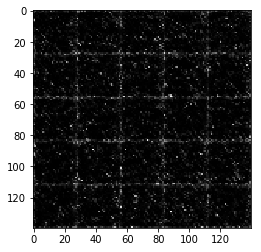

Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931


KeyboardInterrupt: 

In [45]:
batch_size = 32
z_dim = 100
learning_rate = 0.00022
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.6931


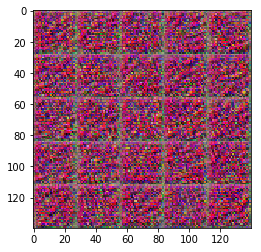

Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6929


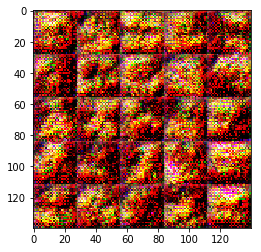

Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.6931


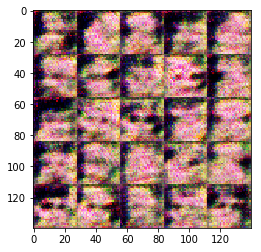

Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.6903


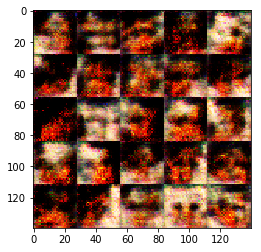

Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.6931


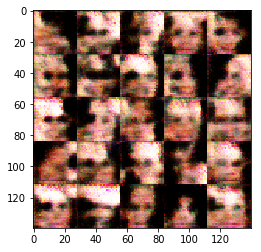

Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6928


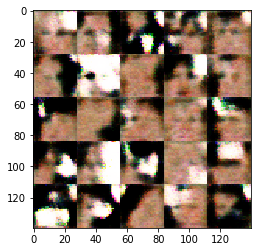

Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.6926


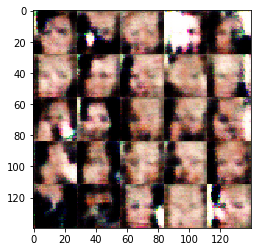

Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.6710


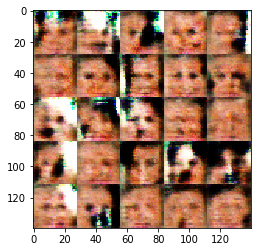

Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.6869


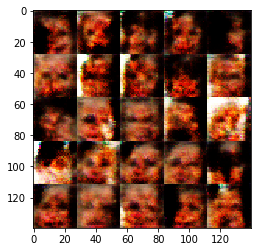

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.6851


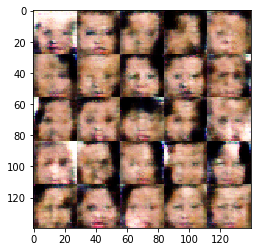

Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.6931


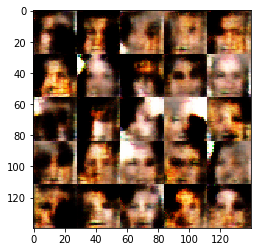

Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.6684


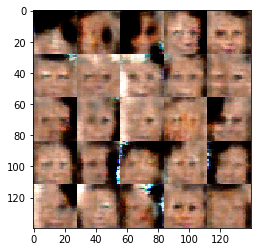

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.6931


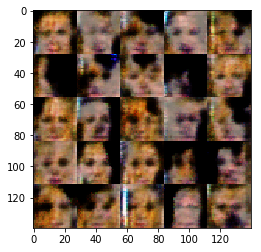

Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6657


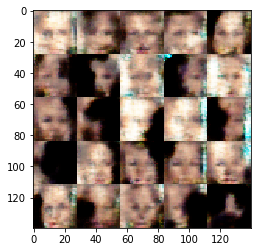

Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.6911


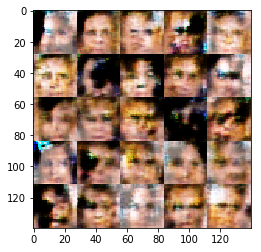

Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6931


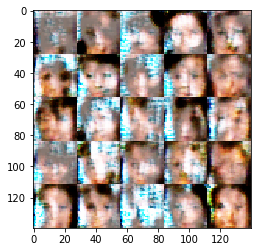

Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.6771


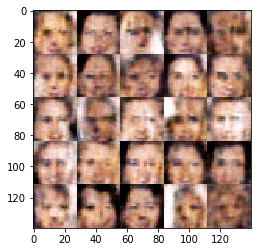

Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6931


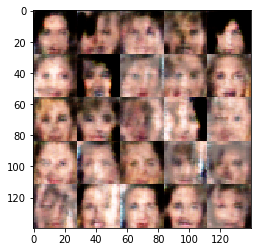

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.6871


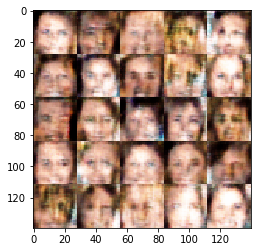

Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.6812


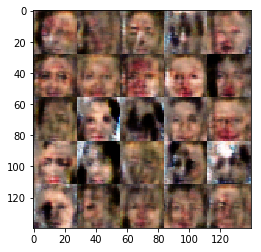

Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.4356
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.6886


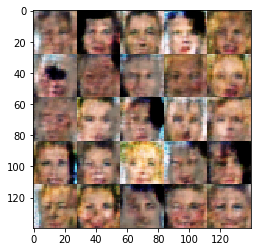

Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.6516


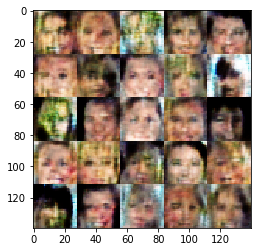

Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.6898


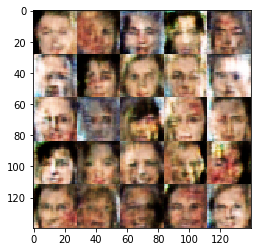

Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.4383


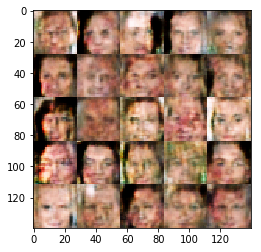

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.6736


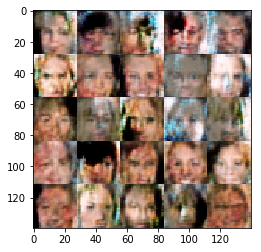

Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.5928


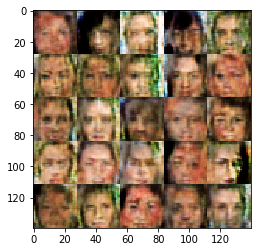

Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.6929


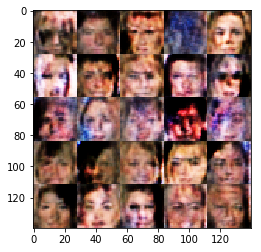

Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.6926


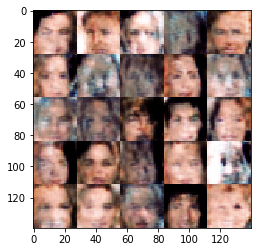

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.6804


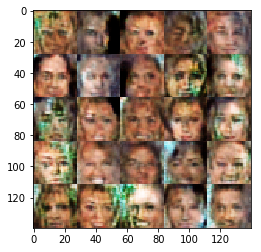

Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6835


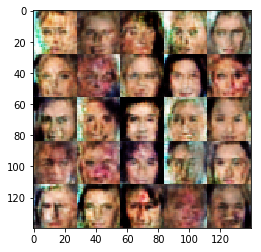

Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.6150


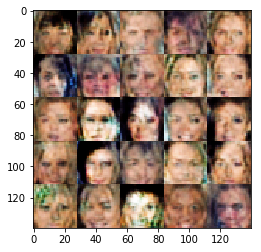

Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.6920


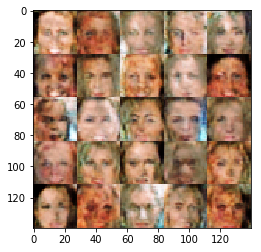

Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.6402


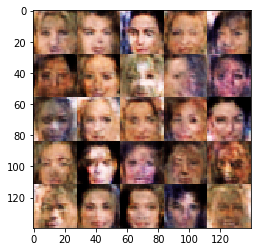

Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.6590


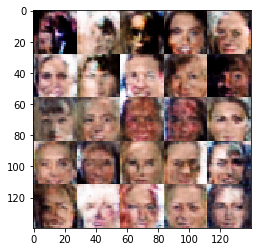

Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.6928


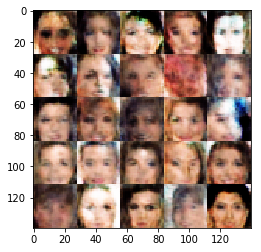

Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.6387


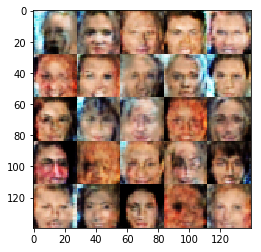

Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.6528


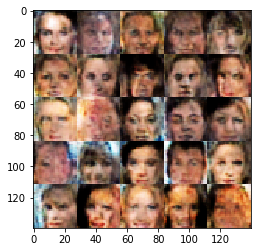

Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6570


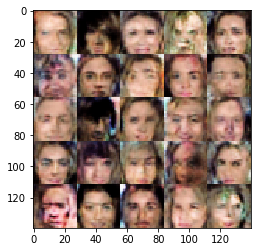

Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.6588


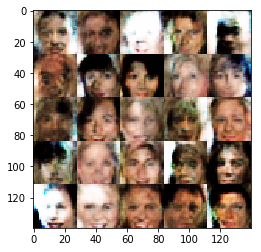

Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.6917


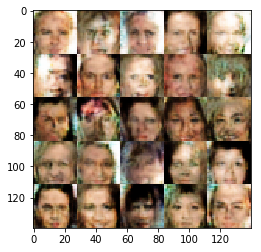

Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.6917


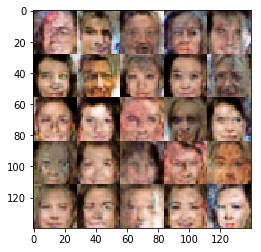

Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6931


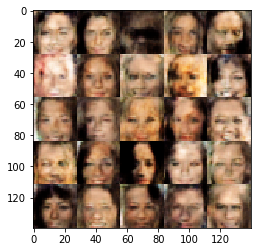

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.6884


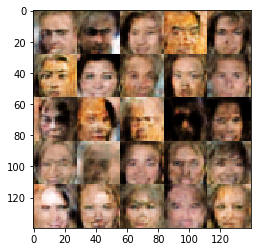

Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.4060


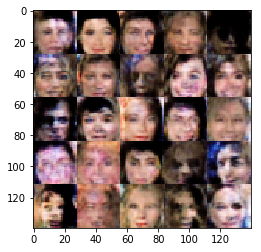

Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6432


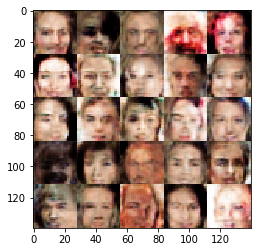

Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.6633


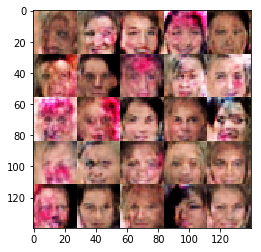

Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.6928


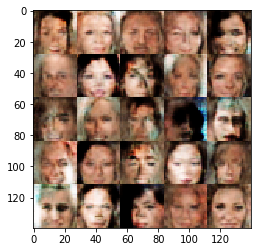

Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.6928


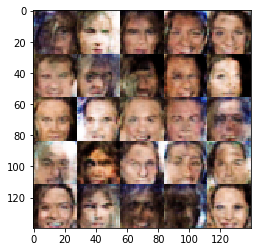

Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.6926


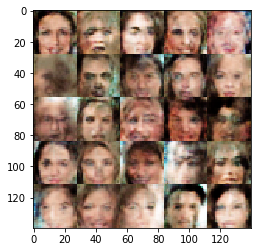

Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.3322


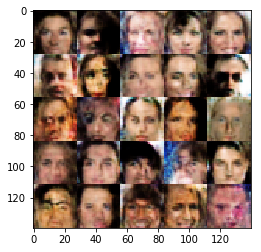

Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.6930


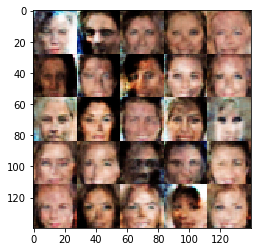

Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.6931


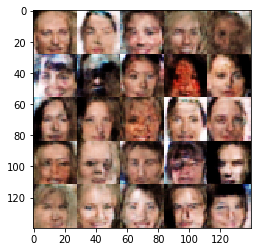

Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.6384


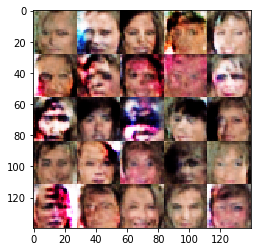

Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.6779


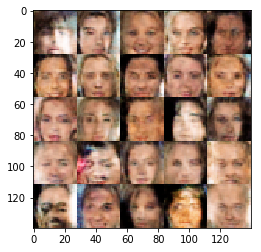

Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.5536


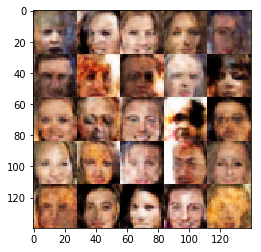

Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.6784


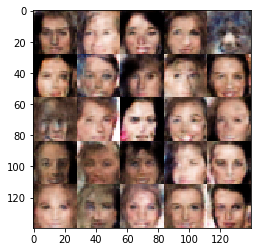

Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.6926


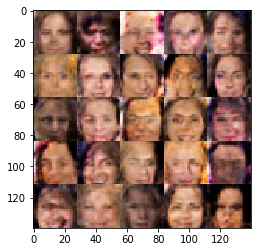

Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.6842


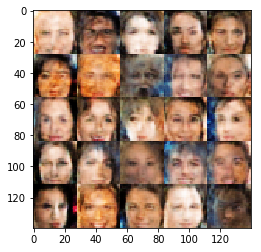

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.6868


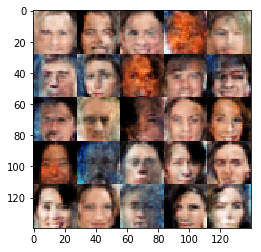

Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.6911


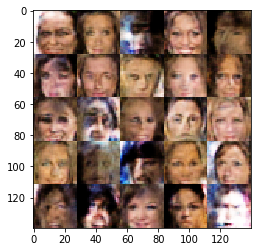

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.6930


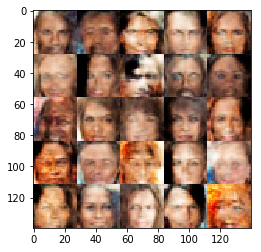

Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.6828


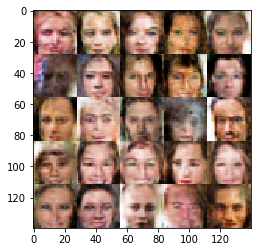

Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6931


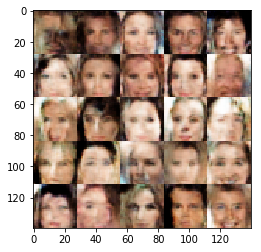

Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.6814


In [46]:
batch_size = 32
z_dim = 100
learning_rate = 0.00022
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.